**Dependecies**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import ResNet50, EfficientNetB4, DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

**Data Ingestion and Exploration**

In [2]:
def load_dataset(data_dir):
    print(f"Loading dataset from {data_dir}")

    images = []
    labels = []


    kau_path = os.path.join(data_dir, "King Abdulaziz University Mammogram Dataset")

    if not os.path.exists(kau_path):
        print(f"Error: Path {kau_path} not found.")
        return None, None


    birads_folders = [d for d in os.listdir(kau_path) if os.path.isdir(os.path.join(kau_path, d)) and d.startswith('birads')]
    birads_mapping = {folder: idx for idx, folder in enumerate(sorted(birads_folders))}

    print(f"Found BI-RADS classes: {birads_mapping}")


    for birads_class, label in birads_mapping.items():
        birads_path = os.path.join(kau_path, birads_class)
        print(f"Processing {birads_class} class (label: {label})...")

        for img_file in os.listdir(birads_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(birads_path, img_file)

                try:
                    img = Image.open(img_path)
                    img = img.convert('RGB')
                    img = img.resize((224, 224))
                    img_array = np.array(img) / 255.0

                    images.append(img_array)
                    labels.append(label)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

    images = np.array(images)
    labels = np.array(labels)

    print(f"Loaded {len(images)} images across {len(birads_mapping)} BI-RADS classes")
    print(f"Label distribution: {np.bincount(labels)}")

    return images, labels

In [3]:
def explore_dataset(images, labels):
    print("\nDataset Exploration:")
    print(f"Total images: {len(images)}")
    print(f"Image shape: {images[0].shape}")


    unique_labels, counts = np.unique(labels, return_counts=True)
    class_distribution = dict(zip(unique_labels, counts))
    print(f"Class distribution: {class_distribution}")


    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()))
    plt.title('Class Distribution')
    plt.xlabel('BI-RADS Class')
    plt.ylabel('Count')
    plt.savefig('class_distribution.png')


    plt.figure(figsize=(12, 8))
    for i, label in enumerate(unique_labels):
        idx = np.where(labels == label)[0][0]
        plt.subplot(1, len(unique_labels), i+1)
        plt.imshow(images[idx])
        plt.title(f'BI-RADS: {label}')
        plt.axis('off')
    plt.savefig('sample_images.png')

    return class_distribution

**Data Preprocessing**

In [4]:
def preprocess_data(images, labels, test_size=0.2, val_size=0.15):

    num_classes = np.max(labels) + 1
    print(f"Number of classes (based on max label + 1): {num_classes}")


    unique_labels = np.unique(labels)
    print(f"Unique labels in dataset: {unique_labels}")

    valid_indices = np.isin(labels, unique_labels)
    filtered_images = images[valid_indices]
    filtered_labels = labels[valid_indices]

    label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
    print(f"Label mapping (old → new): {label_mapping}")

    mapped_labels = np.array([label_mapping[label] for label in filtered_labels])

    X_train, X_test, y_train, y_test = train_test_split(
        filtered_images, mapped_labels, test_size=test_size, random_state=42, stratify=mapped_labels
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size/(1-test_size), random_state=42, stratify=y_train
    )

    num_actual_classes = len(unique_labels)
    y_train_one_hot = to_categorical(y_train, num_actual_classes)
    y_val_one_hot = to_categorical(y_val, num_actual_classes)
    y_test_one_hot = to_categorical(y_test, num_actual_classes)

    print(f"\nPreprocessing complete:")
    print(f"Training set: {X_train.shape[0]} images")
    print(f"Validation set: {X_val.shape[0]} images")
    print(f"Test set: {X_test.shape[0]} images")
    print(f"Number of classes used for training: {num_actual_classes}")

    class_mapping = {new_label: old_label for old_label, new_label in label_mapping.items()}
    original_class_names = {0: 'birads1', 1: 'birads3', 2: 'birads4', 3: 'birads5'}
    class_names = {new_label: original_class_names[old_label] for new_label, old_label in class_mapping.items()}

    return (X_train, y_train, y_train_one_hot), (X_val, y_val, y_val_one_hot), (X_test, y_test, y_test_one_hot), num_actual_classes, class_names

In [5]:
def setup_data_augmentation():
    train_datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )


    valid_datagen = ImageDataGenerator()

    return train_datagen, valid_datagen

In [6]:
def apply_clahe_enhancement(images):
    import cv2
    enhanced_images = []


    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    for img in images:
        lab = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2LAB)

        lab_planes = list(cv2.split(lab))
        lab_planes[0] = clahe.apply(lab_planes[0])

        lab = cv2.merge(lab_planes)
        enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB) / 255.0
        enhanced_images.append(enhanced)

    return np.array(enhanced_images)

**Model Architecture Implementation**

In [7]:
def create_cnn_transformer_backbone(input_shape=(224, 224, 3)):

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)


    for layer in base_model.layers[:100]:
        layer.trainable = False

    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs)

    _, h, w, c = x.shape
    x = layers.Reshape((h * w, c))(x)


    for _ in range(3):

        attention_output = layers.MultiHeadAttention(
            num_heads=8, key_dim=64
        )(x, x)
        x = layers.Add()([x, attention_output])
        x = layers.LayerNormalization(epsilon=1e-6)(x)


        ffn = layers.Dense(2048, activation='relu')(x)
        ffn = layers.Dense(c)(ffn)
        ffn = layers.Dropout(0.1)(ffn)
        x = layers.Add()([x, ffn])
        x = layers.LayerNormalization(epsilon=1e-6)(x)


    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(512, activation='relu')(x)
    backbone_output = layers.Dropout(0.3)(x)

    backbone_model = models.Model(inputs=inputs, outputs=backbone_output, name="hybrid_backbone")
    return backbone_model

In [8]:
def create_risk_assessment_branch(backbone_output, num_classes):
    x = layers.Dense(256, activation='relu')(backbone_output)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='risk_output')(x)

    return outputs

def create_cancer_detection_branch(backbone_output, num_classes):
    x = layers.Dense(256, activation='relu')(backbone_output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='detection_output')(x)

    return outputs

def create_cancer_staging_branch(backbone_output, num_classes):
    x = layers.Dense(256, activation='gelu')(backbone_output)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='gelu')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='staging_output')(x)

    return outputs

def create_risk_factor_branch(backbone_output, num_classes):
    x = layers.Dense(256, activation='relu')(backbone_output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='factor_output')(x)

    return outputs

def create_differential_diagnosis_branch(backbone_output, num_classes):
    x = layers.Dense(256, activation='relu')(backbone_output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='diagnosis_output')(x)

    return outputs


In [9]:
def build_multi_model_system(input_shape=(224, 224, 3), num_classes=3):

    inputs = layers.Input(shape=input_shape)
    backbone = create_cnn_transformer_backbone(input_shape)
    backbone_output = backbone(inputs)


    risk_output = create_risk_assessment_branch(backbone_output, num_classes)
    detection_output = create_cancer_detection_branch(backbone_output, num_classes)
    staging_output = create_cancer_staging_branch(backbone_output, num_classes)
    factor_output = create_risk_factor_branch(backbone_output, num_classes)
    diagnosis_output = create_differential_diagnosis_branch(backbone_output, num_classes)


    model = models.Model(
        inputs=inputs,
        outputs=[
            risk_output,
            detection_output,
            staging_output,
            factor_output,
            diagnosis_output
        ],
        name="breast_cancer_multi_model"
    )


    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss={
            'risk_output': 'categorical_crossentropy',
            'detection_output': 'categorical_crossentropy',
            'staging_output': 'categorical_crossentropy',
            'factor_output': 'categorical_crossentropy',
            'diagnosis_output': 'categorical_crossentropy'
        },
        loss_weights={
            'risk_output': 1.0,
            'detection_output': 1.2,
            'staging_output': 1.0,
            'factor_output': 0.8,
            'diagnosis_output': 1.0
        },
        metrics={
            'risk_output': ['accuracy'],
            'detection_output': ['accuracy'],
            'staging_output': ['accuracy'],
            'factor_output': ['accuracy'],
            'diagnosis_output': ['accuracy']
        }
    )

    return model

**Training and Evaluation**

In [10]:
def train_model(model, train_data, val_data, epochs=50, batch_size=16):
    (X_train, y_train, y_train_one_hot), (X_val, y_val, y_val_one_hot) = train_data, val_data


    checkpoint_cb = callbacks.ModelCheckpoint(
        'best_breast_cancer_model.h5',
        monitor='val_loss',
        save_best_only=True,
        mode='min'
    )

    early_stopping_cb = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    reduce_lr_cb = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )


    train_targets = {
        'risk_output': y_train_one_hot,
        'detection_output': y_train_one_hot,
        'staging_output': y_train_one_hot,
        'factor_output': y_train_one_hot,
        'diagnosis_output': y_train_one_hot
    }

    val_targets = {
        'risk_output': y_val_one_hot,
        'detection_output': y_val_one_hot,
        'staging_output': y_val_one_hot,
        'factor_output': y_val_one_hot,
        'diagnosis_output': y_val_one_hot
    }


    history = model.fit(
        X_train, train_targets,
        validation_data=(X_val, val_targets),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb]
    )

    return model, history

In [11]:
def evaluate_model(model, test_data):
    X_test, y_test, y_test_one_hot = test_data


    test_targets = {
        'risk_output': y_test_one_hot,
        'detection_output': y_test_one_hot,
        'staging_output': y_test_one_hot,
        'factor_output': y_test_one_hot,
        'diagnosis_output': y_test_one_hot
    }


    print("\nEvaluating model on test data:")
    results = model.evaluate(X_test, test_targets, verbose=1)


    predictions = model.predict(X_test)


    branches = ['risk_output', 'detection_output', 'staging_output', 'factor_output', 'diagnosis_output']

    for i, branch in enumerate(branches):
        print(f"\n--- {branch.replace('_output', '').title()} Branch Results ---")


        branch_preds = np.argmax(predictions[i], axis=1)
        branch_true = np.argmax(y_test_one_hot, axis=1)


        accuracy = accuracy_score(branch_true, branch_preds)
        print(f"Accuracy: {accuracy:.4f}")


        print("\nClassification Report:")
        print(classification_report(branch_true, branch_preds))


        cm = confusion_matrix(branch_true, branch_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['BI-RADS 1', 'BI-RADS 3', 'BI-RADS 4', 'BI-RADS 5'],
                    yticklabels=['BI-RADS 1', 'BI-RADS 3', 'BI-RADS 4', 'BI-RADS 5'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix - {branch.replace("_output", "").title()}')
        plt.savefig(f'confusion_matrix_{branch}.png')

    return results, predictions

In [12]:
def visualize_training_history(history):

    metrics = ['loss', 'risk_output_accuracy', 'detection_output_accuracy',
               'staging_output_accuracy', 'factor_output_accuracy', 'diagnosis_output_accuracy']

    plt.figure(figsize=(15, 10))


    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')


    plt.subplot(2, 1, 2)
    for metric in metrics[1:]:
        plt.plot(history.history[metric], label=f'Train {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}', linestyle='--')

    plt.title('Model Accuracy by Branch')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.savefig('training_history.png')

**Explainability and Visualization**

In [13]:
def apply_gradcam(model, img_array, layer_name='hybrid_backbone', pred_index=None, branch='risk_output'):
    original_img = img_array.copy()

    if len(img_array.shape) == 3:
        img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype(np.float32)
    branch_names = ['risk_output', 'detection_output', 'staging_output',
                    'factor_output', 'diagnosis_output']
    try:
        branch_index = branch_names.index(branch)
        print(f"Using branch: {branch} (index {branch_index})")
    except ValueError:
        print(f"Branch {branch} not found, using risk_output")
        branch_index = 0

    backbone = model.get_layer('hybrid_backbone')
    print(f"Backbone found: {backbone.name}, output shape: {backbone.output_shape}")

    if hasattr(backbone, 'layers'):
        for i, layer in enumerate(backbone.layers):
            if i < 5 or i > len(backbone.layers) - 5:
                print(f"Backbone layer {i}: {layer.name}, type: {type(layer).__name__}")
                if hasattr(layer, 'output_shape'):
                    print(f"   Shape: {layer.output_shape}")


    target_layer_output = backbone.output

    input_tensor = tf.convert_to_tensor(img_array)

    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        outputs = model(input_tensor)

        branch_output = outputs[branch_index]

        if pred_index is None:
            pred_index = tf.argmax(branch_output[0])

        class_score = branch_output[:, pred_index]

    grads = tape.gradient(class_score, input_tensor)

    pooled_grads = tf.reduce_mean(grads, axis=(1, 2))


    pooled_grads = tf.expand_dims(tf.expand_dims(pooled_grads, axis=1), axis=1)

    weighted_input = tf.multiply(input_tensor, pooled_grads)


    heatmap = tf.reduce_mean(weighted_input, axis=-1)


    heatmap = tf.maximum(heatmap, 0)[0]


    heatmap = heatmap / (tf.reduce_max(heatmap) + tf.keras.backend.epsilon())
    heatmap = heatmap.numpy()

    import cv2

    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))

    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    img_for_overlay = (original_img * 255).astype(np.uint8)

    if len(img_for_overlay.shape) < 3:
        img_for_overlay = cv2.cvtColor(img_for_overlay, cv2.COLOR_GRAY2BGR)
    elif img_for_overlay.shape[2] == 1:
        img_for_overlay = cv2.cvtColor(img_for_overlay, cv2.COLOR_GRAY2BGR)
    elif img_for_overlay.shape[2] == 3:
        img_for_overlay = cv2.cvtColor(img_for_overlay, cv2.COLOR_RGB2BGR)


    superimposed = cv2.addWeighted(img_for_overlay, 0.6, heatmap_colored, 0.4, 0)

    superimposed = cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB)

    return superimposed

In [14]:
def visualize_model_predictions(model, X_test, y_test, num_samples=5):
    indices = np.random.choice(range(len(X_test)), num_samples, replace=False)

    predictions = model.predict(X_test[indices])

    plt.figure(figsize=(20, 4*num_samples))

    for i, idx in enumerate(indices):
        img = X_test[idx]
        true_label = np.argmax(y_test[idx])
        branches = ['risk_output', 'detection_output', 'staging_output',
                    'factor_output', 'diagnosis_output']

        for j, branch in enumerate(branches):
            branch_pred = np.argmax(predictions[j][i])

            cam_image = apply_gradcam(model, img,
                                     pred_index=branch_pred,
                                     branch=branch)
            plt.subplot(num_samples, len(branches) + 1, i * (len(branches) + 1) + j + 2)
            plt.imshow(cam_image)
            plt.title(f"{branch.split('_')[0].title()}\nPred: BI-RADS {branch_pred+1}")
            plt.axis('off')

        plt.subplot(num_samples, len(branches) + 1, i * (len(branches) + 1) + 1)
        plt.imshow(img)
        plt.title(f"Original\nTrue: BI-RADS {true_label+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('prediction_visualization.png')

**Model Inference Pipeline**

In [15]:
def uncertainty_quantification(model, img, num_samples=10):
    model.trainable = True

    if len(img.shape) == 3:
        img = np.expand_dims(img, axis=0)

    all_predictions = []
    for _ in range(num_samples):
        predictions = model.predict(img)
        all_predictions.append([p[0] for p in predictions])

    mean_preds = []
    std_preds = []

    for i in range(len(all_predictions[0])):
        branch_preds = np.array([pred[i] for pred in all_predictions])
        mean_preds.append(np.mean(branch_preds, axis=0))
        std_preds.append(np.std(branch_preds, axis=0))

    model.trainable = False

    return mean_preds, std_preds

In [16]:
def process_new_image(model, img_path, threshold=0.7):
    img = Image.open(img_path)
    img = img.convert('RGB')
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0

    enhanced_img = apply_clahe_enhancement(np.array([img_array]))[0]

    mean_preds, std_preds = uncertainty_quantification(model, enhanced_img)

    branches = ['Risk Assessment', 'Cancer Detection', 'Cancer Staging',
               'Risk Factor Analysis', 'Differential Diagnosis']
    birads_classes = ['BI-RADS 1', 'BI-RADS 3', 'BI-RADS 4', 'BI-RADS 5']

    results = {}
    for i, branch in enumerate(branches):
        pred_class = np.argmax(mean_preds[i])
        pred_prob = mean_preds[i][pred_class]
        uncertainty = std_preds[i][pred_class]

        needs_review = pred_prob < threshold

        results[branch] = {
            'prediction': birads_classes[pred_class],
            'confidence': float(pred_prob),
            'uncertainty': float(uncertainty),
            'needs_review': needs_review
        }

    gradcam_img = apply_gradcam(model, enhanced_img, 'hybrid_backbone')

    return results, gradcam_img


In [17]:
def generate_report(results, gradcam_img, output_path='report.html'):
    birads_descriptions = {
        'BI-RADS 1': 'Normal mammogram, no significant abnormalities',
        'BI-RADS 3': 'Probably benign finding, short-term follow-up suggested',
        'BI-RADS 4': 'Suspicious abnormality, biopsy should be considered',
        'BI-RADS 5': 'Highly suspicious of malignancy, appropriate action should be taken'
    }

    import cv2
    cv2.imwrite('gradcam.jpg', gradcam_img)

    html_content = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>Breast Cancer Analysis Report</title>
        <style>
            body { font-family: Arial, sans-serif; margin: 20px; }
            .header { text-align: center; margin-bottom: 30px; }
            .results { display: flex; flex-wrap: wrap; }
            .result-card {
                border: 1px solid #ddd;
                border-radius: 5px;
                padding: 15px;
                margin: 10px;
                width: calc(50% - 52px);
            }
            .high-confidence { border-left: 5px solid #4CAF50; }
            .low-confidence { border-left: 5px solid #FF9800; }
            .needs-review { border-left: 5px solid #F44336; }
            .visualization { text-align: center; margin: 20px 0; }
            table { width: 100%; border-collapse: collapse; }
            th, td { padding: 8px; text-align: left; border-bottom: 1px solid #ddd; }
            .footer { margin-top: 30px; font-size: 0.8em; color: #666; }
        </style>
    </head>
    <body>
        <div class="header">
            <h1>Breast Cancer Analysis Report</h1>
            <p>Generated on """ + pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S') + """</p>
        </div>

        <div class="visualization">
            <h2>Region of Interest Visualization</h2>
            <img src="gradcam.jpg" alt="Visualization" style="max-width: 100%; height: auto;">
            <p><em>Heatmap indicates regions influencing the model's decision</em></p>
        </div>

        <h2>Analysis Results</h2>
        <div class="results">
    """


    for branch, data in results.items():
        confidence_class = "high-confidence" if data['confidence'] > 0.8 else "low-confidence"
        if data['needs_review']:
            confidence_class = "needs-review"

        html_content += f"""
        <div class="result-card {confidence_class}">
            <h3>{branch}</h3>
            <table>
                <tr>
                    <th>Prediction:</th>
                    <td><strong>{data['prediction']}</strong></td>
                </tr>
                <tr>
                    <th>Description:</th>
                    <td>{birads_descriptions[data['prediction']]}</td>
                </tr>
                <tr>
                    <th>Confidence:</th>
                    <td>{data['confidence']:.2%}</td>
                </tr>
                <tr>
                    <th>Uncertainty:</th>
                    <td>{data['uncertainty']:.3f}</td>
                </tr>
                <tr>
                    <th>Status:</th>
                    <td>{"<span style='color:#F44336;'>Needs Review</span>" if data['needs_review'] else "<span style='color:#4CAF50;'>Confident Prediction</span>"}</td>
                </tr>
            </table>
        </div>
        """

    html_content += """
        </div>

        <div class="footer"><p>This report is generated by an AI system and should be reviewed by a qualified healthcare professional before making any medical decisions. AI analysis is meant to assist, not replace, professional medical judgment.</p>
        </div>
    </body>
    </html>
    """

    with open(output_path, 'w') as f:
        f.write(html_content)

    print(f"Report generated at {output_path}")

**Main Pipeline Execution**


===== Breast Cancer Analysis Pipeline =====

----- Data Ingestion -----
Loading dataset from /root/.cache/kagglehub/datasets/orvile/kau-bcmd-mamography-dataset/versions/1
Found BI-RADS classes: {'birads1': 0, 'birads3': 1, 'birads4': 2, 'birads5': 3}
Processing birads1 class (label: 0)...
Processing birads3 class (label: 1)...
Processing birads4 class (label: 2)...
Processing birads5 class (label: 3)...
Loaded 1991 images across 4 BI-RADS classes
Label distribution: [1865    0  102   24]

----- Data Exploration -----

Dataset Exploration:
Total images: 1991
Image shape: (224, 224, 3)
Class distribution: {np.int64(0): np.int64(1865), np.int64(2): np.int64(102), np.int64(3): np.int64(24)}

----- Data Preprocessing -----
Applying CLAHE enhancement...
Number of classes (based on max label + 1): 4
Unique labels in dataset: [0 2 3]
Label mapping (old → new): {np.int64(0): 0, np.int64(2): 1, np.int64(3): 2}

Preprocessing complete:
Training set: 1293 images
Validation set: 299 images
Test se

Model: "breast_cancer_multi_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hybrid_backbone     │ (None, 512)       │ 62,433,152 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 256)       │    131,328 │ hybrid_backbone[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 256)       │    131,328 │ hybrid_backbone[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 256)       │    131,328 │ hybrid_backbone[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 256)       │    131,328 │ hybrid_backbone[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │    131,328 │ hybrid_backbone[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256)       │        512 │ dense_11[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_13[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_15[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 256)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 256)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     32,896 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │     32,896 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │     32,896 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 128)       │     32,896 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 128)       │     32,896 │ dropout_11[0][0]

 Total params: 63,259,791 (241.32 MB)

 Trainable params: 59,123,471 (225.54 MB)

 Non-trainable params: 4,136,320 (15.78 MB)


----- Model Training -----
Epoch 1/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - detection_output_accuracy: 0.7679 - detection_output_loss: 0.6419 - diagnosis_output_accuracy: 0.2994 - diagnosis_output_loss: 1.4352 - factor_output_accuracy: 0.5790 - factor_output_loss: 0.9134 - loss: 4.0322 - risk_output_accuracy: 0.8121 - risk_output_loss: 0.5771 - staging_output_accuracy: 0.8739 - staging_output_loss: 0.5187

81/81 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - detection_output_accuracy: 0.7684 - detection_output_loss: 0.6412 - diagnosis_output_accuracy: 0.3004 - diagnosis_output_loss: 1.4328 - factor_output_accuracy: 0.5802 - factor_output_loss: 0.9115 - loss: 4.0245 - risk_output_accuracy: 0.8130 - risk_output_loss: 0.5756 - staging_output_accuracy: 0.8745 - staging_output_loss: 0.5173 - val_detection_output_accuracy: 0.9365 - val_detection_output_loss: 0.8429 - val_diagnosis_output_accuracy: 0.0502 - val_diagnosis_output_loss: 1.0031 - val_factor_output_accuracy: 0.9365 - val_factor_output_loss: 0.2697 - val_loss: 2.8736 - val_risk_output_accuracy: 0.9365 - val_risk_output_loss: 0.3445 - val_staging_output_accuracy: 0.9365 - val_staging_output_loss: 0.2836 - learning_rate: 1.0000e-04
Epoch 2/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - detection_output_accuracy: 0.9083 - detection_output_loss: 0.4174 - diagnosis_output_accuracy: 0.6569 - diagnosis_output_loss: 0.7511 - factor_output_accuracy: 0.83

81/81 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - detection_output_accuracy: 0.9084 - detection_output_loss: 0.4172 - diagnosis_output_accuracy: 0.6580 - diagnosis_output_loss: 0.7497 - factor_output_accuracy: 0.8368 - factor_output_loss: 0.4579 - loss: 2.3860 - risk_output_accuracy: 0.9290 - risk_output_loss: 0.4316 - staging_output_accuracy: 0.9326 - staging_output_loss: 0.3378 - val_detection_output_accuracy: 0.9365 - val_detection_output_loss: 0.6269 - val_diagnosis_output_accuracy: 0.9365 - val_diagnosis_output_loss: 0.3738 - val_factor_output_accuracy: 0.9365 - val_factor_output_loss: 0.4973 - val_loss: 2.1030 - val_risk_output_accuracy: 0.9365 - val_risk_output_loss: 0.2794 - val_staging_output_accuracy: 0.9365 - val_staging_output_loss: 0.2881 - learning_rate: 1.0000e-04
Epoch 3/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 246ms/step - detection_output_accuracy: 0.9264 - detection_output_loss: 0.3481 - diagnosis_output_accuracy: 0.8630 - diagnosis_output_loss: 0.4506 - factor_output_accuracy: 0.9

81/81 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - detection_output_accuracy: 0.9519 - detection_output_loss: 0.2091 - diagnosis_output_accuracy: 0.9552 - diagnosis_output_loss: 0.2426 - factor_output_accuracy: 0.9578 - factor_output_loss: 0.2062 - loss: 1.1172 - risk_output_accuracy: 0.9479 - risk_output_loss: 0.2492 - staging_output_accuracy: 0.9502 - staging_output_loss: 0.2095 - val_detection_output_accuracy: 0.9666 - val_detection_output_loss: 0.1776 - val_diagnosis_output_accuracy: 0.9431 - val_diagnosis_output_loss: 0.2216 - val_factor_output_accuracy: 0.9465 - val_factor_output_loss: 0.1913 - val_loss: 1.1471 - val_risk_output_accuracy: 0.9365 - val_risk_output_loss: 0.2517 - val_staging_output_accuracy: 0.9365 - val_staging_output_loss: 0.2920 - learning_rate: 1.0000e-04
Epoch 6/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 25s 250ms/step - detection_output_accuracy: 0.9370 - detection_output_loss: 0.2392 - diagnosis_output_accuracy: 0.9491 - diagnosis_output_loss: 0.2464 - factor_output_accuracy: 0.9

81/81 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - detection_output_accuracy: 0.9378 - detection_output_loss: 0.2390 - diagnosis_output_accuracy: 0.9519 - diagnosis_output_loss: 0.2026 - factor_output_accuracy: 0.9556 - factor_output_loss: 0.2193 - loss: 1.1725 - risk_output_accuracy: 0.9431 - risk_output_loss: 0.2673 - staging_output_accuracy: 0.9325 - staging_output_loss: 0.2403 - val_detection_output_accuracy: 0.9632 - val_detection_output_loss: 0.1640 - val_diagnosis_output_accuracy: 0.9599 - val_diagnosis_output_loss: 0.1616 - val_factor_output_accuracy: 0.9599 - val_factor_output_loss: 0.1667 - val_loss: 0.8665 - val_risk_output_accuracy: 0.9599 - val_risk_output_loss: 0.1912 - val_staging_output_accuracy: 0.9599 - val_staging_output_loss: 0.1718 - learning_rate: 5.0000e-05
Epoch 14/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 23s 252ms/step - detection_output_accuracy: 0.9585 - detection_output_loss: 0.1722 - diagnosis_output_accuracy: 0.9577 - diagnosis_output_loss: 0.1799 - factor_output_accuracy: 0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


--- Detection Branch Results ---
Accuracy: 0.9774

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       374
           1       0.94      0.80      0.86        20
           2       0.00      0.00      0.00         5

    accuracy                           0.98       399
   macro avg       0.64      0.60      0.62       399
weighted avg       0.96      0.98      0.97       399


--- Staging Branch Results ---
Accuracy: 0.9674

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       374
           1       0.92      0.60      0.73        20
           2       0.00      0.00      0.00         5

    accuracy                           0.97       399
   macro avg       0.63      0.53      0.57       399
weighted avg       0.95      0.97      0.96       399



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


--- Factor Branch Results ---
Accuracy: 0.9774

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       374
           1       0.94      0.80      0.86        20
           2       0.00      0.00      0.00         5

    accuracy                           0.98       399
   macro avg       0.64      0.60      0.62       399
weighted avg       0.96      0.98      0.97       399


--- Diagnosis Branch Results ---
Accuracy: 0.9699

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       374
           1       0.93      0.65      0.76        20
           2       0.00      0.00      0.00         5

    accuracy                           0.97       399
   macro avg       0.63      0.55      0.58       399
weighted avg       0.96      0.97      0.96       399



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



----- Model Interpretability -----
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Using branch: risk_output (index 0)
Backbone found: hybrid_backbone, output shape: (None, 512)
Backbone layer 0: input_layer_2, type: InputLayer
Backbone layer 1: resnet50, type: Functional
   Shape: (None, 7, 7, 2048)
Backbone layer 2: reshape, type: Reshape
Backbone layer 3: multi_head_attention, type: MultiHeadAttention
Backbone layer 4: add, type: Add
Backbone layer 26: layer_normalization_5, type: LayerNormalization
Backbone layer 27: global_average_pooling1d, type: GlobalAveragePooling1D
Backbone layer 28: dense_6, type: Dense
Backbone layer 29: dropout_6, type: Dropout
Using branch: detection_output (index 1)
Backbone found: hybrid_backbone, output shape: (None, 512)
Backbone layer 0: input_layer_2, type: InputLayer
Backbone layer 1: resnet50, type: Functional
   Shape: (None, 7, 7, 2048)
Backbone layer 2: reshape, type: Reshape
Backbone layer 3: multi_head_attention, type: MultiHeadAttention
Backbone layer 

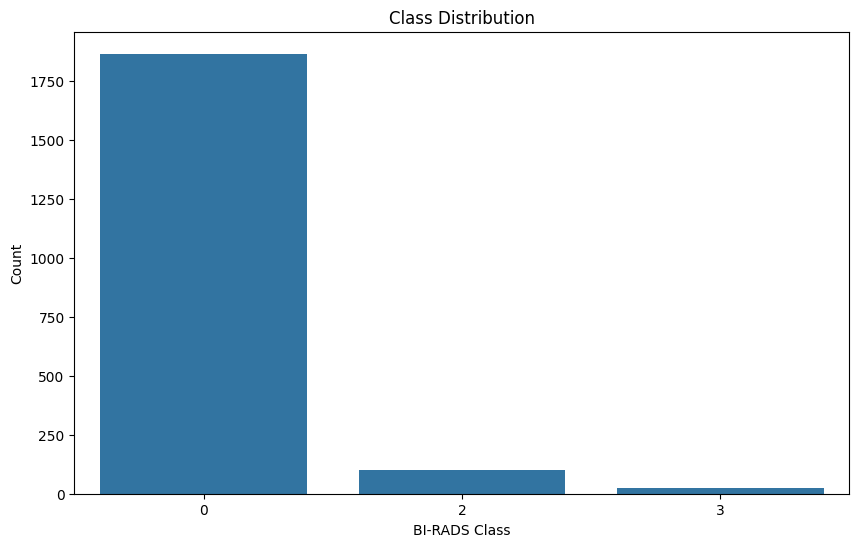

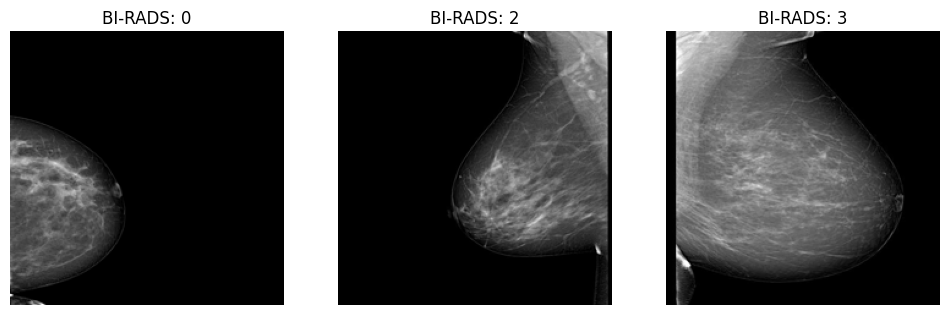

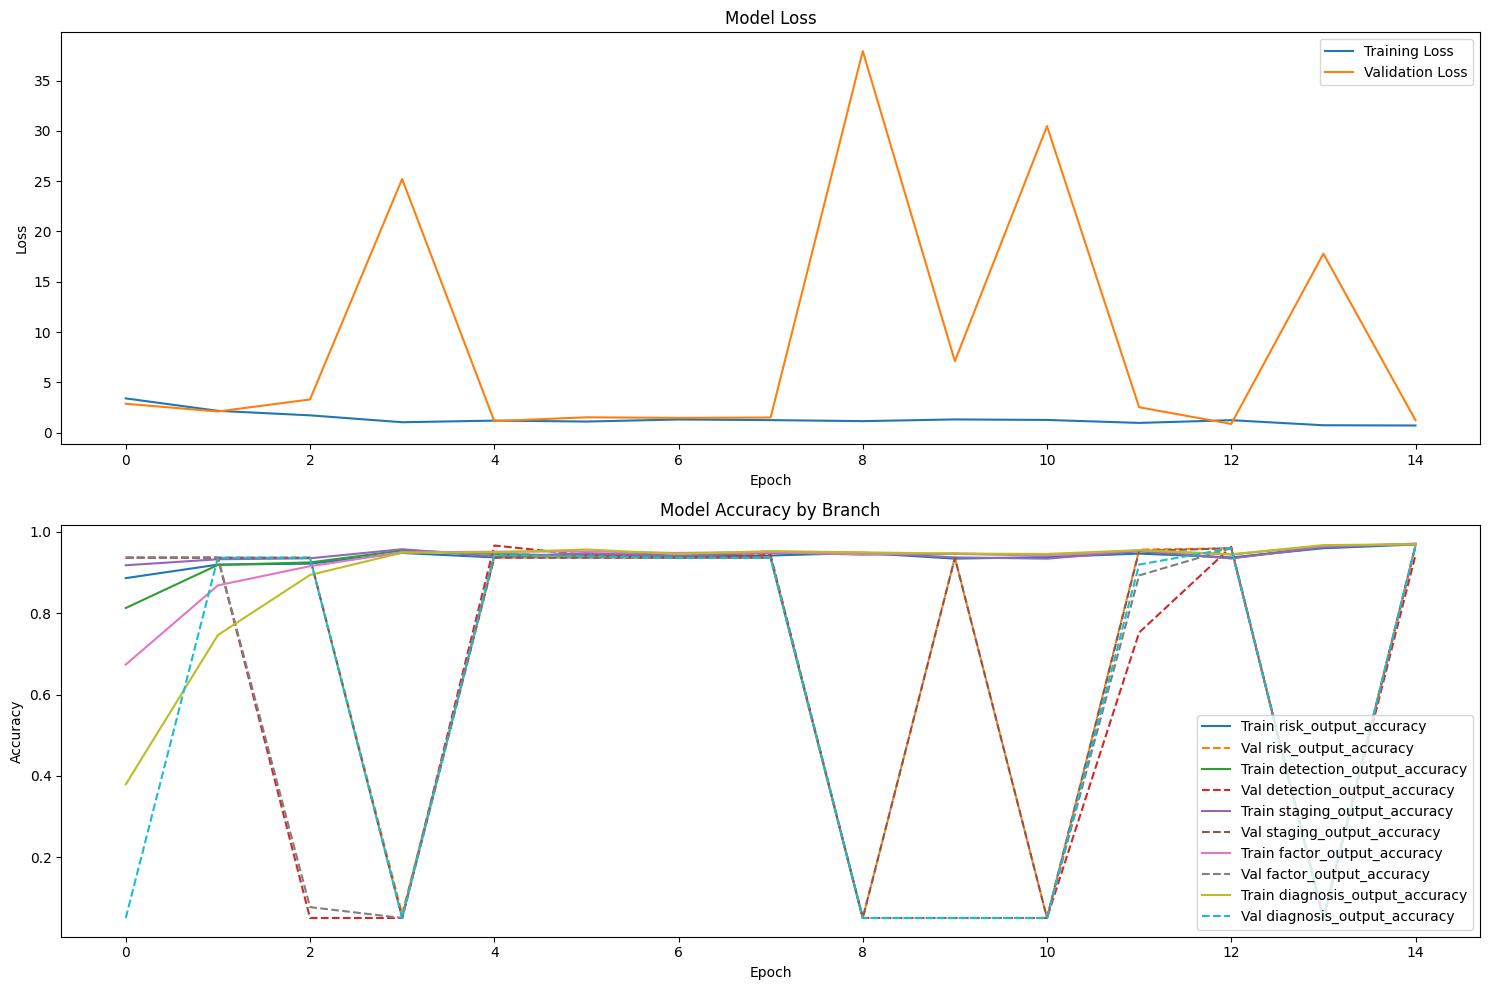

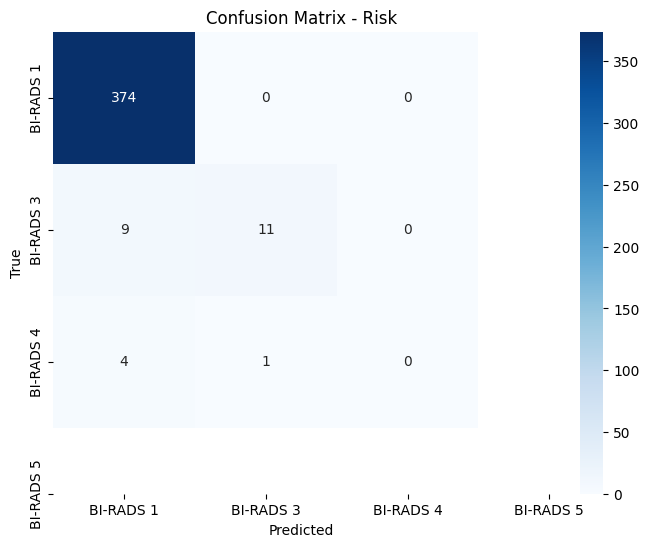

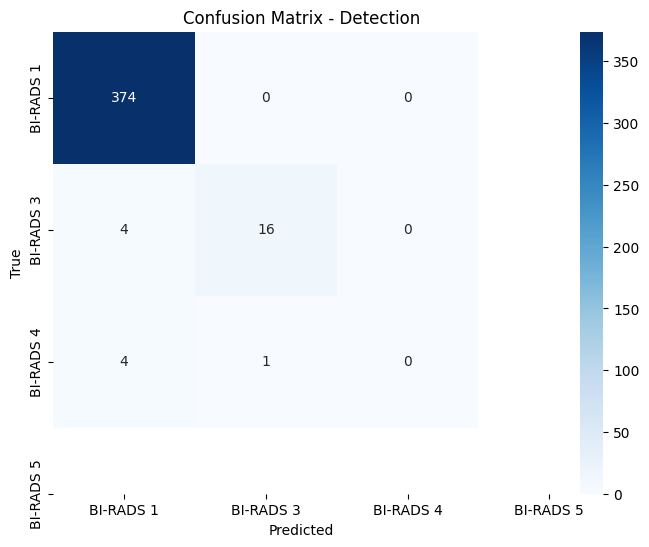

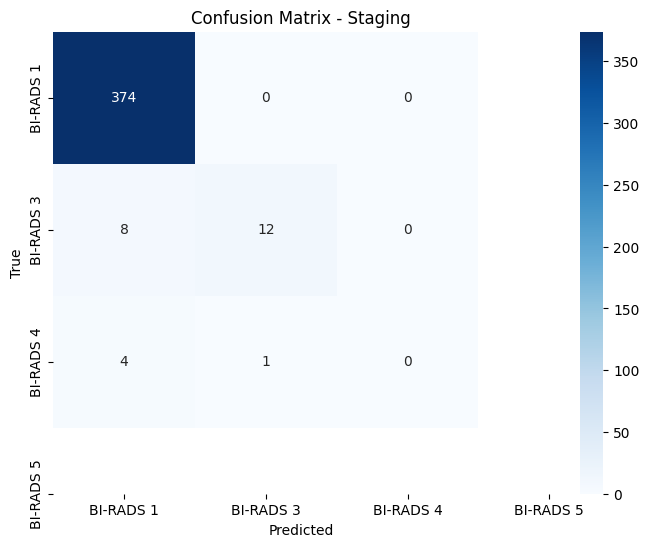

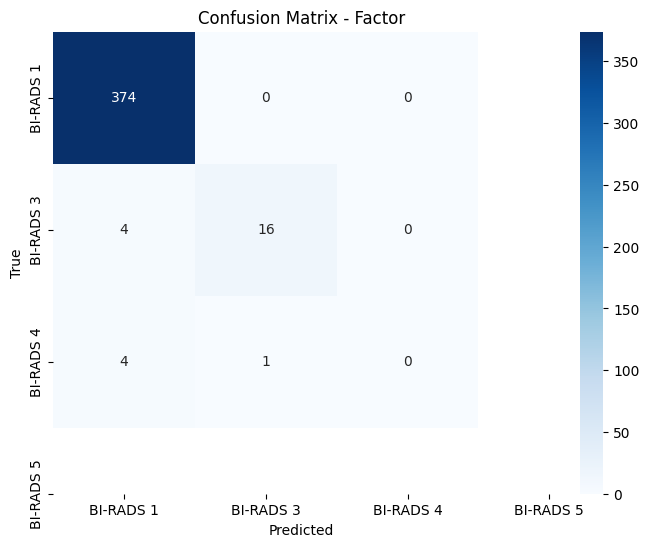

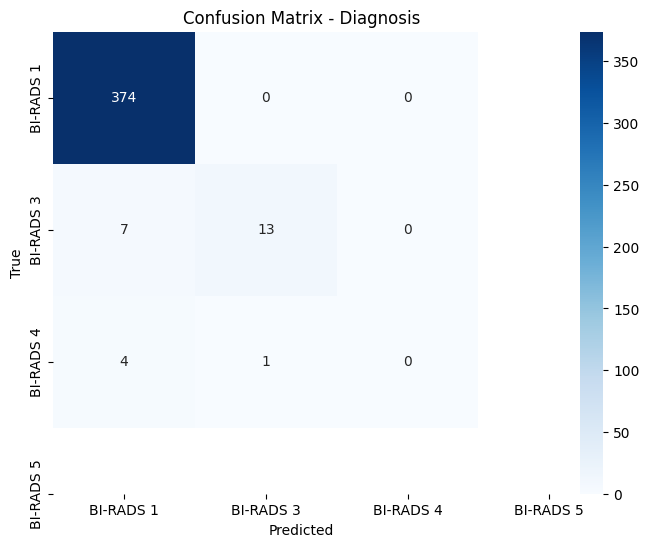

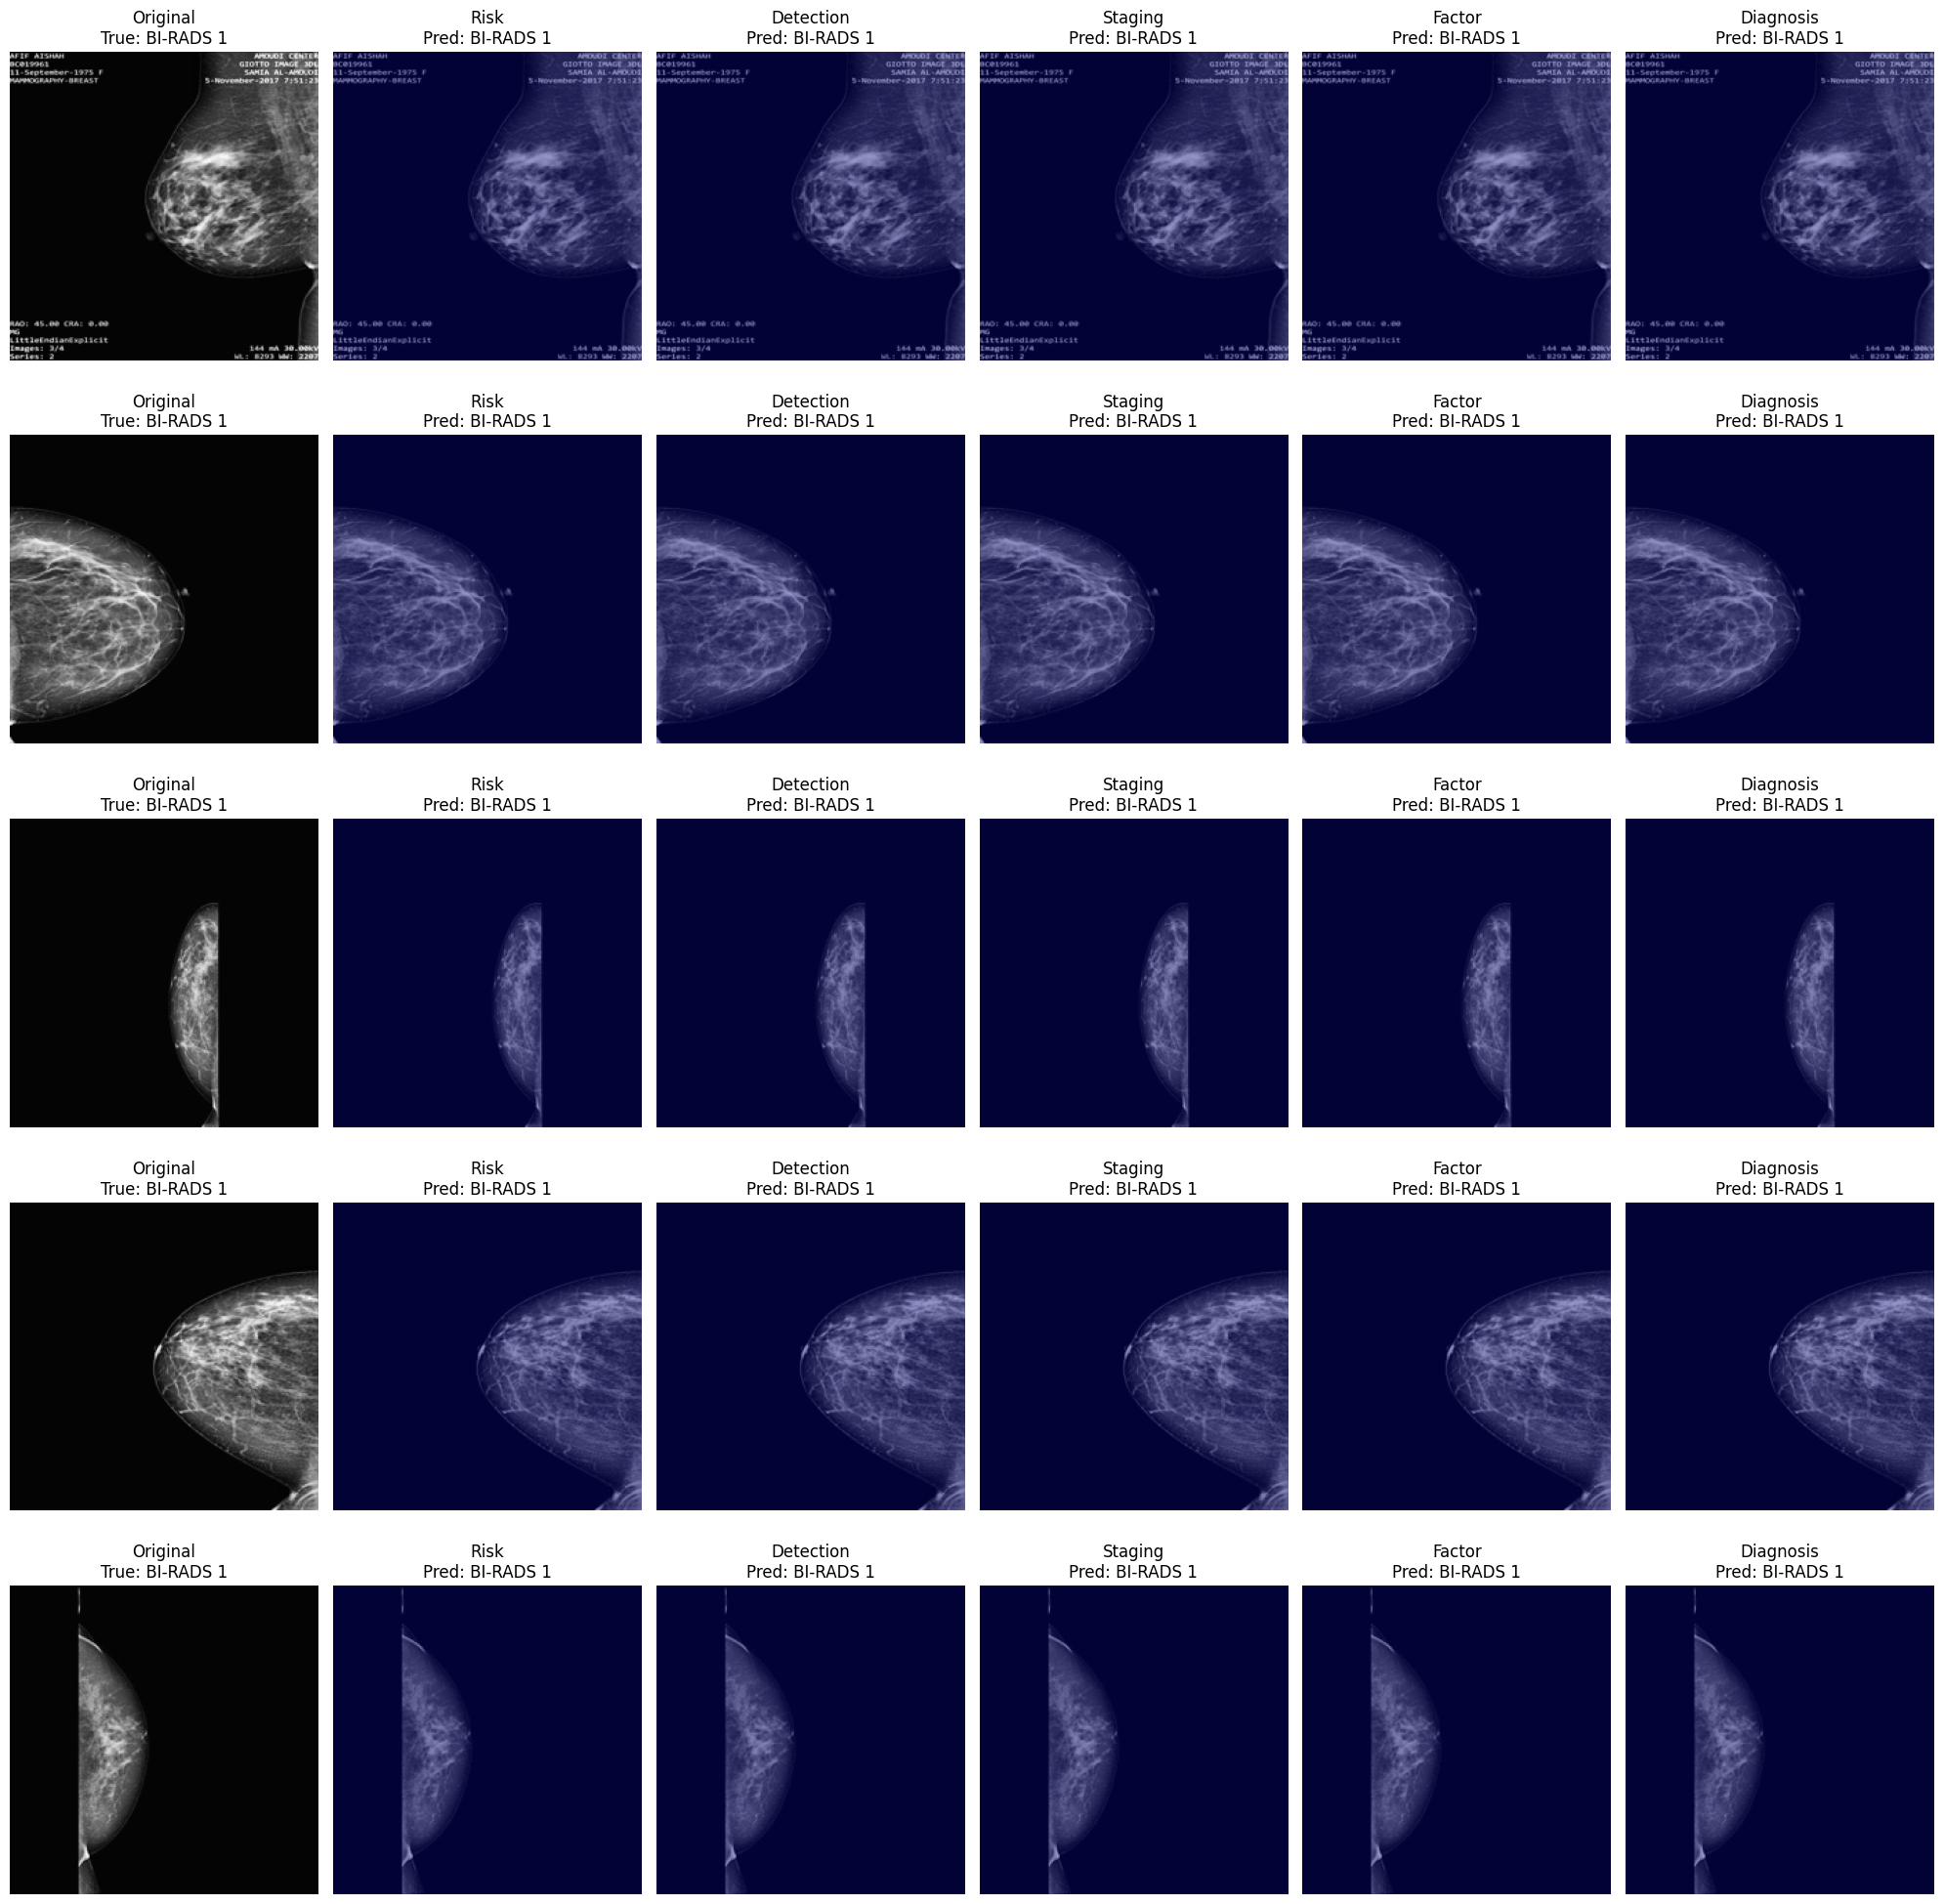

In [18]:
def main():
    print("\n===== Breast Cancer Analysis Pipeline =====")

    # 1. Data Ingestion
    print("\n----- Data Ingestion -----")
    import kagglehub

    path = kagglehub.dataset_download("orvile/kau-bcmd-mamography-dataset")

    if not os.path.exists(path):
        print(f"Error: Dataset directory {path} not found.")
        print("Please download the dataset using: kagglehub.dataset_download('orvile/kau-bcmd-mamography-dataset')")
        return

    images, labels = load_dataset(path)

    # 2. Data Exploration
    print("\n----- Data Exploration -----")
    class_distribution = explore_dataset(images, labels)

    # 3. Data Preprocessing
    print("\n----- Data Preprocessing -----")


    print("Applying CLAHE enhancement...")
    enhanced_images = apply_clahe_enhancement(images)


    train_data, val_data, test_data, num_classes, class_names = preprocess_data(enhanced_images, labels)
    print(f"Class names mapping: {class_names}")


    train_datagen, valid_datagen = setup_data_augmentation()

    # 4. Model Building
    print("\n----- Model Building -----")
    model = build_multi_model_system(input_shape=(224, 224, 3), num_classes=num_classes)
    print("Model architecture created.")


    model.summary()

    # 5. Model Training
    print("\n----- Model Training -----")
    model, history = train_model(model, train_data, val_data, epochs=15)

    # 6. Visualize Training History
    print("\n----- Training Visualization -----")
    visualize_training_history(history)

    # 7. Model Evaluation
    print("\n----- Model Evaluation -----")
    results, predictions = evaluate_model(model, test_data)

    # 8. Interpretability Visualization
    print("\n----- Model Interpretability -----")
    X_test, y_test, _ = test_data
    visualize_model_predictions(model, X_test, y_test)

    # 9. Demo Inference Pipeline
    print("\n----- Inference Pipeline  -----")
    # use a test image
    sample_idx = np.random.choice(len(X_test))
    sample_img = X_test[sample_idx]

    # Save sample image for processing
    sample_img_path = "sample_mammogram.png"
    plt.imsave(sample_img_path, sample_img)

    # Process image
    results, gradcam_img = process_new_image(model, sample_img_path)

    # Generate report
    generate_report(results, gradcam_img)

    print("\n===== Pipeline Execution Complete =====")
    print("Model trained and evaluated successfully!")
    print("Sample inference performed and report generated.")

if __name__ == "__main__":
    main()